In [1]:
# from google.colab import drive
# drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
# !unzip "/content/MyDrive/MyDrive/Deep Decrumple Classifier/Arshasb_7k.zip" -d "/content/MyDrive/MyDrive/Deep Decrumple Classifier/persion_Data"

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
from scipy.ndimage import rotate, zoom

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
map_data_dir = "Maps/"
img_data_dir = "Images/"
runs_dir = "Classifier/runs/"
model_name = "Persian_data_classifier_first_run"
model_dir = runs_dir + model_name + "/"
if os.listdir(runs_dir).count(model_name) == 0:
    os.mkdir(runs_dir + model_name)
maps = os.listdir(map_data_dir)
dmaps = [m for m in maps if m[0] == "d"]
gmaps = [m for m in maps if m[0] == "g"]
maps = os.listdir(map_data_dir)
resume_from_last = False
train_val_split_rate = 0.9
n_crumples = len(dmaps)
idxs = np.arange(n_crumples)
np.random.shuffle(idxs)
e_crumple_idxs = idxs[:int(n_crumples * train_val_split_rate)]
f_crumple_idxs = idxs[int(n_crumples * train_val_split_rate):]
train_val_split_rate = 0.9
Batch_size = 1000
Epochs = 70
Val_Batch_size = 40
total_chunks = 67
images_per_chunk = 1000
steps_per_epoch = int(images_per_chunk * train_val_split_rate) * total_chunks
steps_per_val_epoch = int(images_per_chunk * (1 - train_val_split_rate)) * total_chunks
saved_models_list = os.listdir(runs_dir + model_name)
key_func = lambda x:int(x.split("_")[-1][:-3]) if x[-3:] == ".h5" else 0
saved_models_list.sort(key=key_func)
if resume_from_last:
    last_epoch = int(saved_models_list[-1].split("_")[-1][:-3])
else:
    last_epoch = -1

In [4]:
def quick_deformation(crumple_id, img):
    global dmaps, gmaps, map_data_dir
    g_map = np.load(map_data_dir + gmaps[crumple_id])
    d_map = np.load(map_data_dir + dmaps[crumple_id])
    ret = np.zeros_like(img)
    print("d_map.shape:", d_map.shape, "\tg_map.shape:", g_map.shape, "\timg.shape:", img.shape)
    ret[...] = img[:, d_map[..., 0], d_map[..., 1], :] * np.expand_dims(g_map, 2)
    return ret

In [5]:
def data_gen(training=True, batch_size=1):
    global e_crumple_idxs, f_crumple_idxs, total_chunks, train_val_split_rate, images_per_chunk
    if training:
        crumple_idxs = e_crumple_idxs
        start_batch = 0
        end_batch = int(images_per_chunk * train_val_split_rate)
    else:
        crumple_idxs = f_crumple_idxs
        start_batch = int(images_per_chunk * train_val_split_rate)
        end_batch = images_per_chunk
    crumple_i = 0
    while 1:
        for chunk_num in range(total_chunks):
            for j in range(start_batch, end_batch, batch_size):
                imgs = np.load(img_data_dir + str(chunk_num) + ".npy", mmap_mode="r")
                im = np.expand_dims(imgs[j:j + batch_size], -1)
                cr_id = crumple_idxs[crumple_i]
                cr_im_norm = np.subtract(im,  127.5)
                y = np.zeros((cr_im_norm.shape[0], 1))
                y[0, :] = 1
                cr_im_0 = np.copy(cr_im_norm)
                y_0 = np.copy(y)
                im = np.expand_dims(imgs[j:j + batch_size], -1)
                cr_id = crumple_idxs[crumple_i]
                cr_im = quick_deformation(cr_id, im)
                cr_im_norm = np.subtract(cr_im,  127.5)
                y = np.zeros((cr_im.shape[0], 1))
                y[0, :] = 0
                yield np.concatenate([cr_im_0, cr_im], axis=0), np.concatenate([y_0, y], axis=0)
                crumple_i = (crumple_i + 1) % len(crumple_idxs)

In [6]:
if not resume_from_last:
    FACTOR = .25
    x_inp = tf.keras.layers.Input(shape=(180, 180, 1))
    padding_layer = tf.keras.layers.ZeroPadding2D(padding=(2, 2))(x_inp) # 184
    c1 = tf.keras.layers.Conv2D(int(24 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(padding_layer) # 184
    c_dial_1 = tf.keras.layers.Conv2D(int(8 * FACTOR), (3, 3), dilation_rate=1, padding="same", activation=tf.nn.leaky_relu)(padding_layer)
    c1_out = tf.keras.layers.Concatenate(axis = 3)([c1, c_dial_1])
    c2 = tf.keras.layers.Conv2D(int(12 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c1_out) # 184
    c_dial_2 = tf.keras.layers.Conv2D(int(4 * FACTOR), (3, 3), dilation_rate=1, padding="same", activation=tf.nn.leaky_relu)(c1_out)
    c2_out = tf.keras.layers.Concatenate(axis = 3)([c2, c_dial_2])
    c3 = tf.keras.layers.Conv2D(int(12 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c2_out) # 184
    c_dial_3 = tf.keras.layers.Conv2D(int(4 * FACTOR), (3, 3), dilation_rate=1, padding="same", activation=tf.nn.leaky_relu)(c2_out)
    c3_out = tf.keras.layers.Concatenate(axis = 3)([c3, c_dial_3])
    c4 = tf.keras.layers.Conv2D(int(12 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c3_out) # 184
    c_dial_4 = tf.keras.layers.Conv2D(int(4 * FACTOR), (3, 3), dilation_rate=1, padding="same", activation=tf.nn.leaky_relu)(c3_out)
    c4_out = tf.keras.layers.Concatenate(axis = 3)([c4, c_dial_4])
    c5 = tf.keras.layers.Conv2D(int(12 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c4_out) # 184
    c_dial_5 = tf.keras.layers.Conv2D(int(4 * FACTOR), (3, 3), dilation_rate=1, padding="same", activation=tf.nn.leaky_relu)(c4_out)
    c5_out = tf.keras.layers.Concatenate(axis = 3)([c5, c_dial_5])
    p1 = tf.keras.layers.MaxPooling2D()(c5_out)
    c5 = tf.keras.layers.Conv2D(int(16 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p1) # 92
    c6 = tf.keras.layers.Conv2D(int(16 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c5) # 92
    p2 = tf.keras.layers.MaxPooling2D()(c6)
    c7 = tf.keras.layers.Conv2D(int(32 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p2) # 46
    c8 = tf.keras.layers.Conv2D(int(32 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c7) # 46
    p3 = tf.keras.layers.MaxPooling2D()(c8)
    c9 = tf.keras.layers.Conv2D(int(64 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p3) # 23
    c10 = tf.keras.layers.Conv2D(int(64 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c9) # 23
    # c11 = tf.keras.layers.Conv2D(int(64 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c10) # 23
    # c12 = tf.keras.layers.Conv2D(int(64 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c11) # 23
    p4 = tf.keras.layers.MaxPooling2D()(c10)
    c11 = tf.keras.layers.Conv2D(int(128 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p4) # 12
    c12 = tf.keras.layers.Conv2D(int(128 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c11) # 12
    p5 = tf.keras.layers.MaxPooling2D()(c12)
    c13 = tf.keras.layers.Conv2D(int(256 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p5) # 12
    c14 = tf.keras.layers.Conv2D(int(256 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c13) # 12
    p6 = tf.keras.layers.MaxPooling2D()(c14)
    c15 = tf.keras.layers.Conv2D(int(512 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(p6) # 6
    c16 = tf.keras.layers.Conv2D(int(256 * FACTOR), (3, 3), padding="same", activation=tf.nn.leaky_relu)(c15) # 6
    p7 = tf.keras.layers.GlobalMaxPooling2D()(c16)
    out_layer = tf.keras.layers.Dense(1, activation="sigmoid")(p7)
    model = tf.keras.models.Model(inputs=[x_inp], outputs=[out_layer])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss="binary_crossentropy")
else:
    model = tf.keras.models.load_model(runs_dir + "/" + model_name + "/" + os.listdir(runs_dir + model_name)[-2])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 184, 184, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 184, 184, 6)  60          ['zero_padding2d[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)              (None, 184, 184, 2)  20          ['zero_padding2d[0][0]']     

In [ ]:
for e in range(last_epoch + 1, Epochs):
    print("Epoch", e + 1, "/", Epochs, ":")
    x_train, y_train = next(data_gen(training=True, batch_size=Batch_size))
    x_val, y_val = next(data_gen(training=False, batch_size=Val_Batch_size))
    model.fit(x=x_train,
              y=y_train,
              validation_data=(x_val, y_val),
              batch_size=Batch_size,
              epochs=1,
              steps_per_epoch=steps_per_epoch,
              validation_steps=steps_per_val_epoch)

    model.save(model_dir + model_name + "_" + str(e) + ".h5")
    plt.close()

Epoch 1 / 70 :
d_map.shape: (180, 180, 2) 	g_map.shape: (180, 180) 	img.shape: (20, 180, 180, 1)
d_map.shape: (180, 180, 2) 	g_map.shape: (180, 180) 	img.shape: (40, 180, 180, 1)
60300/60300 [==============================] - 18s 112us/step - loss: 0.6549 - val_loss: 0.5685


c:\Users\Pouya\anaconda3\envs\general\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2 / 70 :
d_map.shape: (180, 180, 2) 	g_map.shape: (180, 180) 	img.shape: (20, 180, 180, 1)


: 

In [37]:
c = 0
while True:
    a, b = next(data_gen(training=True, batch_size=Batch_size))
    a.shape, b.shape
    c = c + 1

d_map.shape: (180, 180, 2) 	g_map.shape: (180, 180) 	img.shape: (1000, 180, 180, 1)
d_map.shape: (180, 180, 2) 	g_map.shape: (180, 180) 	img.shape: (1000, 180, 180, 1)


KeyboardInterrupt: 

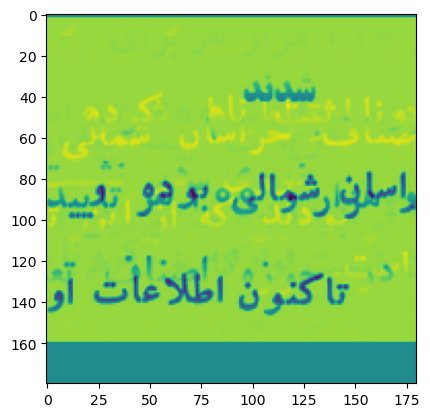

In [44]:
plt.imshow(a[3])



In [30]:
def zoom_by_shape(img, z):
    res = np.zeros((1000,180,180))
    for i in range(1000):    
        x1 = int(np.random.uniform(0,z))
        x2 = z- x1
        y1 = int(np.random.uniform(0,z))
        y2 = z- y1
        cropped = img[i,x1:-x2,y1:-y2]
        res[i] = zoom(cropped, zoom = 180/(220-z))
        if res[i].shape != (180, 180):
            print(info)
            print(i, cropped.shape, res[i].shape, x1, x2, y1, y2, z)
    
    return res
    

(1000, 220, 220)


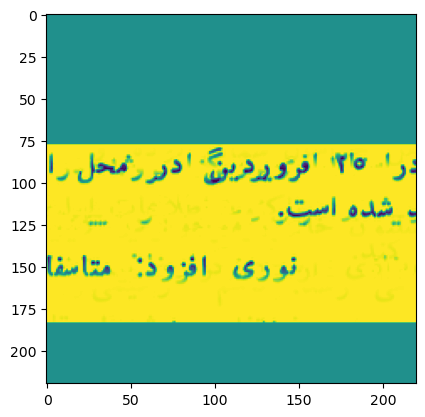

In [47]:
a = np.load("Images/0.npy")
r = rotate(a, angle = np.random.uniform(-5, 5), reshape = False)
plt.imshow(r[1])
print(r.shape)

In [23]:
b = zoom_by_shape(a,50)

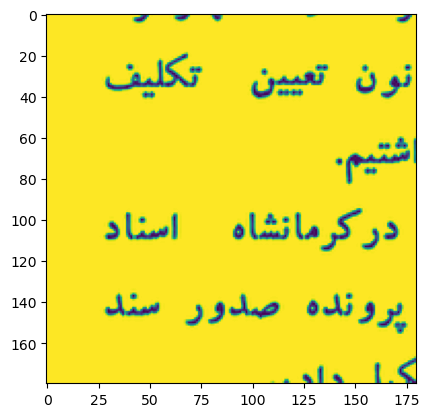

In [27]:
plt.imshow(b[999])

In [26]:
for i in range(0,1000,110):
    print(b[i].shape)
print(b[999].shape)

(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)
(180, 180)


In [52]:
def rotate_by_shape(img):
    res = np.zeros((1000,180,180))
    for i in range(1000):
        res[i] = rotate(img[i], angle = np.random.uniform(-5, 5), reshape = False)
    return res
    

(1000, 180, 180)


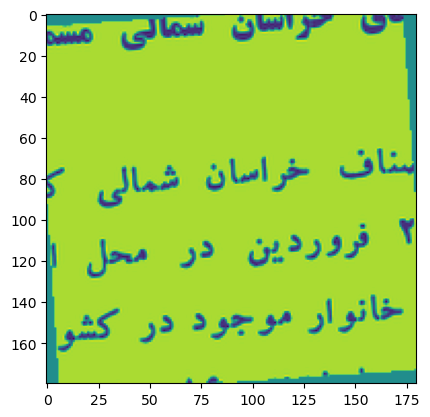

In [54]:
a = np.load("Images/0.npy")
g = zoom_by_shape(a,40)
r = rotate_by_shape(g)
plt.imshow(r[1])
print(r.shape)

In [ ]:
a = np.load("Images/0.npy")
g = zoom_by_shape(a,40)
r = rotate_by_shape(g)
plt.imshow(r[1])
print(r.shape)

In [55]:
def rotate_by_shape1(img):
    res = np.zeros((1000,220,220))
    for i in range(1000):
        res[i] = rotate(img[i], angle = np.random.uniform(-5, 5), reshape = False)
    return res

(1000, 180, 180)


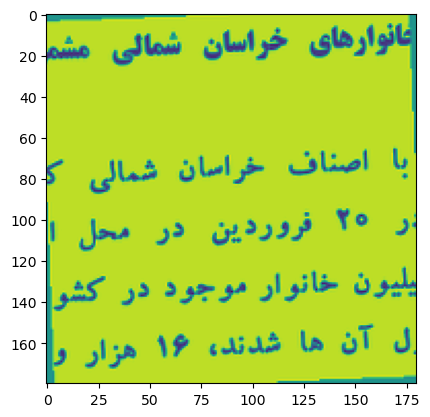

In [60]:
r = rotate_by_shape2(a)
g = zoom_by_shape(r,1)

plt.imshow(g[1])
print(g.shape)

In [61]:
def zoom_by_shape_mahyar(img, z, info):
    res = np.zeros((1000,180,180))
    for i in range(1000):
        x1 = int(np.random.uniform(0, z))
        x2 = z - x1
        y1 = int(np.random.uniform(0, z))
        y2 = z - y1
        cropped = img[i, x1: - x2, y1: - y2]
        transformed = zoom(cropped, zoom = 180 / (220 - z))
        if res[i].shape != transformed.shape:
            print(info)
            print(i, cropped.shape, transformed.shape, x1, x2, y1, y2, z)
        res[i] = transformed
    return res
    

In [63]:
d = np.load("Maps/gmap_0_2_5.300167756805844.npy")
d.shape



(180, 180)